# Off-policy divergence: Baird's MDP

This notebook implements an empirical proof of `off-policy` divergence using [Baird's MDP]()

> `Exercise 11.3`: Apply one-step semi-gradient Q-learning to Baird’s counterexample and show empirically that its weights diverge.
> 
> [Sutton & Barto's RL Introduction book](http://incompleteideas.net/book/RLbook2020.pdf)


<img src="https://lcalem.github.io/imgs/sutton/bairds.png" 
     alt="Sutton &amp; Barto summary chap 11 - Off-policy methods for approximation ..."
     width="650"
/>

More generally, off-policy divergence occurs when we have instances of the [Deadly Triad](https://arxiv.org/pdf/1812.02648v1.pdf):

 - **Function approximation**: (e.g., linear function approximation or ANNs)
 - **Bootstrapping**: Update targets that include existing estimates (as in dynamic programming or TD methods) rather than relying exclusively on actual rewards and complete returns (as in MC methods)
 - **Off-policy training**: Training on a distribution of transitions other than that produced by the target policy

## Parameters

In [176]:
n_states = 7
n_actions = 2
steps = 1000
step_size = 0.01  # alpha
discount_factor = 0.99  # gamma

## Environment

In [173]:
import numpy as np


class BairdMDP:
    def __init__(self, n_states: int, n_actions: int):
        self.n_states = n_states
        self.n_actions = n_actions  # dashed & solid
        self.state = None

    def _random_state(self, n):
        # uniform probability over 0..n states
        return np.random.choice(np.arange(n), p=np.ones(n) * 1 / n)

    def reset(self):
        self.state = self._random_state(self.n_states)
        return self.state, {}  # state, info

    def step(self, action: int):
        if action < 0 or action > self.n_actions - 1:
            raise ValueError(f"Invalid action {action}. Not between 0 and 1")

        if action == 0:
            self.state = self._random_state(self.n_states - 1)
        elif action == 1:
            self.state = self.n_states - 1

        # next_state, reward, terminated, truncated, info
        return self.state, 0, False, False, {}

## Estimator

In [200]:
class Estimator:
    def __init__(self, n_states: int):
        # W is an R^8 vector as described in Fig. 11.2 of Sutton & Barto's book:
        # i.e.: W = (1, 1, 1, 1, 1, 1, 10, 1)
        self.weights = np.ones(n_states + 1)
        self.weights[n_states - 1] = 10
        # Value function as described inside each state in the MDP diagram:
        # i.e.: an |S| x d matrix, with d = |S|+1
        # whose rows are the feature vectors x(s) one for each state S
        self.features = np.eye(n_states, n_states + 1)
        self.features[:n_states, : n_states - 1] *= 2
        self.features[:, -1] = 1
        self.features[-1][-1] = 2

    def __call__(self, s: int) -> float:
        if s < 0 or s > n_states - 1:
            raise ValueError(
                f"State '{s}' out of range. Must be within 0 and {n_states - 1}"
            )
        if a < 0 or a > n_actions - 1:
            raise ValueError(
                f"Action '{a}' out of range. Must be within 0 and {n_actions - 1}"
            )

        return np.dot(self.weights, self.features[s])

## Off-policy TD(0): Q-learning

Here we use the `td-error`: $ \delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1},w_t) - \hat{v}(S_t, w_t) $

Being the weights update the one used in the **semi-gradient TD(0) algorithm**. 

  0%|          | 0/1000 [00:00<?, ?it/s]

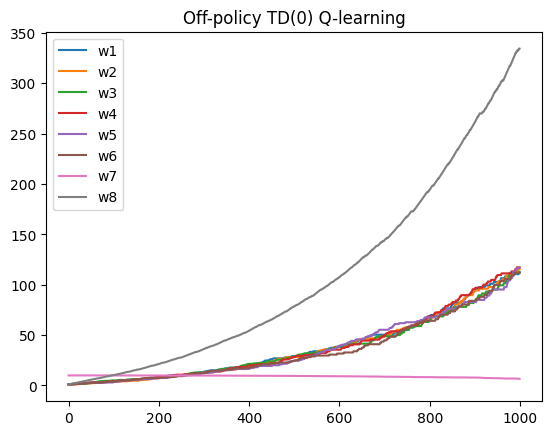

In [227]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class TDEstimator(Estimator):
    def update(self, state: int, reward: float, next_state: int) -> float:
        dv_dw = self.features[state]
        delta = reward + discount_factor * self(next_state) - self(state)
        self.weights += step_size * delta * dv_dw

        return delta


def td_learning():
    def b_policy(state):
        return np.random.choice(
            np.arange(n_actions), p=[(n_states - 1) / n_states, 1 / n_states]
        )

    env = BairdMDP(n_states, n_actions)
    V = TDEstimator(n_states)

    state, _ = env.reset()

    ws = []
    for i in tqdm(range(steps)):
        # chose action using the behaviour policy and take a step
        action = b_policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Q learning update:
        # If we are to follow the target policy, then we always end up in state 7
        V.update(state, reward, n_states - 1)

        # Track the weights and loss evolution
        ws.append(V.weights.copy())

        state = next_state

    # Plot the weight values over time
    ws = np.array(ws)
    plt.plot(ws)
    plt.title("Off-policy TD(0) Q-learning")
    plt.legend([f"w{i+1}" for i in range(ws.shape[-1])])
    plt.show()


# Run & plot
td_learning()

## TDC: TD(0) with gradient Correction

> Also known as **GTD**

To solve the divergence issue, we need to go from a semi-gradient algorithm to a complete gradient to benefit from the convergence 
guarantees of SGD methods. 

To do so we have several _objective function_ options:

 - $\overline{TDE}(w)$: mean square TD error
 
 - $\overline{BE}$: Bellman Error which is closely related to the TD error (_the Bellman error for a state is the expected TD error in that state_).

These error objectives and the corresponding weight-update rules are refered to as `residual-gradient algorithms`. 

With function aproximation (where $\lvert W \rvert \lt \lvert S \rvert$) we cannot compute the actual _Bellman Error_ 
as it is outside the sub-space of the function aproximator, hence we must project it back into the representable space. 

The objective to minimize becomes the `mean square Projected Bellman error`:

$$
\overline{PBE}(w) = \lVert \delta\bar{\Pi}_w \rVert_{\mu}^2
$$

Where $\bar{\delta}_w \in \mathbb{R}^s$ is the `Bellman Error` vector:

$$
\DeclareMathOperator*{\E}{\mathbb{E}}
\newcommand\given[1][]{\:#1\vert\:}
\bar{\delta}_w(s) = \E_{\pi} \left[ R_{t+1} + \gamma v_w(S_{t+1}) - v_w(S_t) \given S_t=s, A_t \sim \pi \right]
$$

> ☝ Notice that the `Bellman Error` is the expected `TD-error`

> 🤓 For a deeper dive in the formulation see `Figure 11.5` from [Sutton & Barto's RL introduction book](http://incompleteideas.net/book/RLbook2020.pdf) and [GTD2](https://www.ics.uci.edu/~dechter/courses/ics-295/winter-2018/papers/2009-sutton-Fast_gradient-descent.pdf).
----

> 🫢😯🕵🤯
>
> Using the `TDEstimator` update with the **b_policy** next state seems to produce the expected results,
> although the formulation and equations look like a complete re-working from the `off-policy TD` example

In [305]:
# d = n_states + 1

# s = 3
# ns = 5
# delta = reward + discount_factor * V(ns) - V(s)
# D = np.eye(n_states)
# X = V.features

# t1 = delta * np.dot(D, X)
# t2 = np.dot(X.T, np.dot(D, X))
# t3 = np.dot(X.T, D) * delta
# # np.dot(t1, t2)
# t = np.dot(np.dot(t1, t2), t3)
# sum(np.diag(t))

0.06472963430083364

  0%|          | 0/1000 [00:00<?, ?it/s]

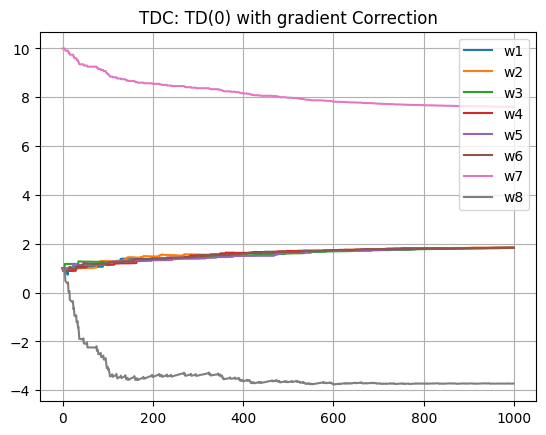

In [306]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class TDCEstimator(Estimator):
    def update(self, state: int, reward: float, next_state: int) -> float:
        xs = self.features[state]
        xns = self.features[next_state]
        delta = reward + discount_factor * self(next_state) - self(state)
        self.weights += step_size * (
            delta * xs - discount_factor * xns * xs * self(state)
        )

        d = n_states + 1
        return delta * np.outer(np.eye(d), self.features)


def tdc_learning():
    def b_policy(state):
        return np.random.choice(
            np.arange(n_actions), p=[(n_states - 1) / n_states, 1 / n_states]
        )

    env = BairdMDP(n_states, n_actions)
    V = TDCEstimator(n_states)

    state, _ = env.reset()

    ws = []
    loss = []
    for i in tqdm(range(steps)):
        # chose action using the behaviour policy and take a step
        action = b_policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Q learning update:
        # If we are to follow the target policy, then we always end up in state 7
        error = V.update(state, reward, next_state)

        # Track the weights evolution
        ws.append(V.weights.copy())
        loss.append(error)

        state = next_state

    # Plot the weight values over time
    ws = np.array(ws)
    plt.plot(ws)
    plt.grid(True)
    # plt.plot(np.sqrt(loss))
    plt.title("TDC: TD(0) with gradient Correction")
    plt.legend([f"w{i+1}" for i in range(ws.shape[-1])] + ["BE"])
    plt.show()

    return V


# Run & plot
V = tdc_learning()